## PUBG Finish Placement Prediction  -PUBG遊戲結束排名預測
- 在PUBG遊戲中，每場比賽最多有100名玩家（matchId）。玩家可以在團隊中（groupId）根據有多少其他團隊在被淘汰時還活著而在遊戲結束時排名（winPlacePerc）。在遊戲中，玩家可以拿起不同的彈藥，恢復被擊倒但未被擊倒的隊友，駕駛車輛，游泳，跑步，射擊，並體驗所有後果 - 例如跌得太遠或者自己跑過來 消除自己。
- 您將獲得大量匿名的PUBG遊戲統計數據，其格式設置為每行包含一個玩家的遊戲後統計數據。數據來自所有類型的比賽：一個人，雙人，小隊和自定義; 不保證每場比賽有100名玩家，每組最多4名玩家。
- 你必須創建一個模型，根據他們的最終統計數據預測玩家的結束排名，從1（第一名）到0（最後一名）

### 評估
- 兩個 column，分別為測試集的ID (ID)、最終排名的預測機率值 (WinPlaceperC) 
- 評估指標為預期的WinPlaceperC和觀察到的WinPlaceperC之間的平均絕對誤差 MAE。

### 特徵定義
- assists - 傷害過多少敵人（最終該敵人被隊友殺害）
- boosts - 使用過多少個提升性的物品(boost items used)
- damageDealt - 造成的總傷害-自己所受的傷害
- DBNOs - 擊倒多少敵人 
- headshotKills - 通過爆頭而殺死的敵人數量
- heals - 使用了多少救援類物品
- Id - 玩家ID
- killPlace - 殺死敵人數量的排名
- killPoints - 基於殺戮的玩家外部排名。將其視為Elo排名，只有殺死才有意義。如果rankPoints中的值不是-1，那麽killPoints中的任何0都應被視為“無”。
- killStreaks - 短時間內殺死敵人的最大數量
- kills - 殺死的敵人的數量
- longestKill - 玩家和玩家在死亡時被殺的最長距離。 這可能會產生誤導，因為擊倒一名球員並開走可能會導致最長的殺戮統計數據。
- matchDuration - 匹配用了多少秒
- matchId - 匹配的ID（每一局一個ID）
- matchType -  單排/雙排/四排；標準模式是“solo”，“duo”，“squad”，“solo-fpp”，“duo-fpp”和“squad-fpp”; 其他模式來自事件或自定義匹配。
- rankPoints - 類似Elo的玩家排名。 此排名不一致，並且在API的下一個版本中已棄用，因此請謹慎使用。值-1表示“無”。
- revives - 玩家救援隊友的次數
- rideDistance - 玩家使用交通工具行駛了多少米
- roadKills - 在交通工具上殺死了多少玩家
- swimDistance - 遊泳了多少米
- teamKills - 該玩家殺死隊友的次數
- vehicleDestroys - 毀壞了多少交通工具
- walkDistance - 步行運動了多少米
- groupId - 隊伍的ID。 如果同一組玩家在不同的比賽中比賽，他們每次都會有不同的groupId。
- numGroups - 在該局比賽中有玩家數據的隊伍數量
- maxPlace - 在該局中已有數據的最差的隊伍名詞（可能與該局隊伍數不匹配，因為數據收集有跳躍）
- weaponsAcquired - 撿了多少把槍
- winPoints - 基於贏的玩家外部排名。將其視為Elo排名，只有獲勝才有意義。如果rankPoints中的值不是-1，那麽winPoints中的任何0都應被視為“無”。
- winPlacePerc - 預測目標，是以百分數計算的，介於0-1之間，1對應第一名，0對應最後一名。 它是根據maxPlace計算的，而不是numGroups，因此匹配中可能缺少某些隊伍。

In [94]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, LabelEncoder # 用於特徵提取, 將數值資料轉為離散

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LogisticRegression, LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, roc_auc_score, accuracy_score
from scipy.stats import uniform
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
from keras.utils import np_utils
from tensorflow.keras.layers import Dense      # Dense 建立網路
from tensorflow.keras.models import Sequential # Sequential 初始化神經網路

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_row', 200) 
pd.set_option('display.max_columns', 100) 
# plt 顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
# 忽略警告
import warnings
warnings.filterwarnings("ignore")
# 避開科學記號顯示數值
pd.set_option('display.float_format','{:}'.format)
# # 數值顯示至小數點後第二位
pd.set_option('display.precision', 2)

In [95]:
# 載入訓練資料集
train = pd.read_csv('./data/pubg/train_V2.csv')
train.head(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.0,0,0,0,60,1241,0,0,0.0,1306,squad-fpp,28,26,-1,0,0.0,0,0.0,0,0,244.8,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.0,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.0,5,0,0.64
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.0,0,0,0,47,0,0,0,0.0,1318,duo,50,47,1491,0,0.0,0,0.0,0,0,161.8,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.9,0,0,0,75,0,0,0,0.0,1436,squad-fpp,31,30,1408,0,0.0,0,0.0,0,0,202.7,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.0,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0,0,0.0,0,0,49.75,2,0,0.1875


In [96]:
# 載入測試資料集
test = pd.read_csv('./data/pubg/test_V2.csv')
test.head(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,0,0,0,0.0,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.1,0,0,2,11,0,2,1,361.9,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.4,0,0,4,49,0,0,0,0.0,1793,squad-fpp,28,27,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,0,0,0,0.0,1834,duo-fpp,45,44,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.2,1,2,1,7,0,3,1,60.06,1326,squad-fpp,28,27,1480,1,0.0,0,0.0,0,0,2963.0,4,0


### 資料量太大, 因此針對降低記憶體空間做處理

In [97]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 288.39 MB
Decreased by 70.7%
Memory usage of dataframe is 413.18 MB
Memory usage after optimization is: 121.74 MB
Decreased by 70.5%


### 觀察資料
- 發現跟ID有關的都是object型態, 還有matchtype也是
- winPlacePerc為福點數型態
- 資料快1G, 資料集非常大

In [98]:
# 確認資料特徵類型
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

In [99]:
# 確認資料特徵類型
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934174 entries, 0 to 1934173
Data columns (total 28 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

### 分析資料
- 透過ID判斷是否為同一場的玩家
- 根據我自己的遊戲經驗，考慮重要的特徵, 例如殺戮的數量，殺傷量，步行距離，玩家拿起的槍支數量和救援物品數量。根據中的這些特徵進行分析，以了解特徵的分佈和特性

In [100]:
# 看一下配對ID一樣的人數
print("相同配對id的人數: "+ str(len(train[train['matchId']=='aeb375fc57110c'])))

相同配對id的人數: 91


### 移除無法作為特徵的欄位

In [101]:
# 觀察移除欄位後的資料及尺寸
train = train.drop(['Id','groupId','matchId','matchType'], axis = 1) # 刪除指定column
test = test.drop(['Id','groupId','matchId','matchType'], axis = 1) # 刪除指定column

# 合併 train & test 資料集
X = pd.concat([train, test], ignore_index = True)

print('train_data shape: '+str(train.shape))
print('y_train shape: '+str(y_train.shape))
print('test shape: '+str(test.shape))

train_data shape: (4446966, 25)
y_train shape: (3811347,)
test shape: (1934174, 24)


#### 檢查缺失值 Missing Value

Text(0.5, 1.0, '資料集中的缺失值數量')

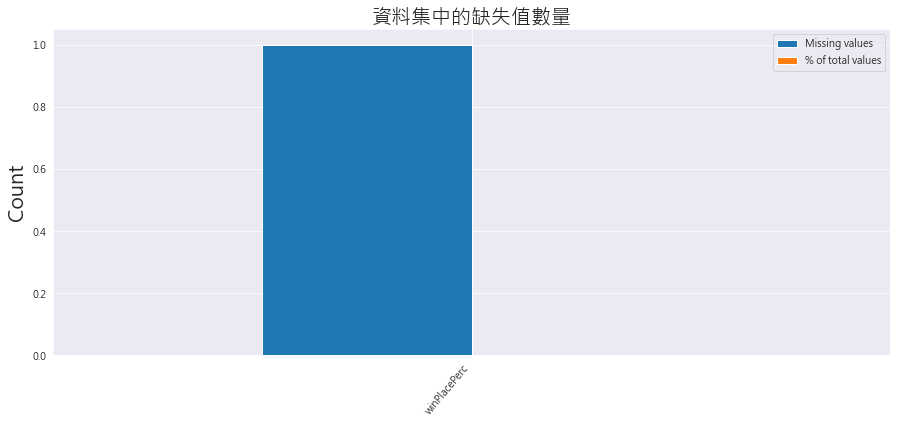

In [102]:
# 定義缺失值檢測函數
def missing_value_table(df):
    
    # 計算所有的缺失值
    mis_val = df.isnull().sum()
    
    # 佔 % 比
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # 合併
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # 給予合併的表格 每個column各一個新名字
    mis_val_rename = mis_val_table.rename(columns = {0:'Missing values', 1:'% of total values'})
    
    # 剔除沒有缺失值的 並 排序
    # 判斷所有數據中的第一 row .iloc[:,1]!=0] 不等於 0的 
    # .iloc[:,1] 代表Missing value 那個 column
    mis_val_rename = mis_val_rename[mis_val_rename.iloc[:,1]!=0].sort_values('Missing values',ascending=False)
    
    return mis_val_rename

missing_value_table(train).plot(kind="bar", figsize = (15,6), fontsize = 10)
plt.xticks(rotation=50, ha='right')
plt.ylabel("Count", fontsize = 20)
plt.title("資料集中的缺失值數量", fontsize = 20)

In [103]:
# 目標值有缺失值的row移除
train = train.dropna(axis=0, subset = ["winPlacePerc"])

#### 異常值檢查與處理 outlier

In [104]:
# 建立異常值index陣列
outlier_indices = []

# 計算每個特徵的四分位數
for column in train.columns:
    if column in ['Id','groupId','matchId','matchType']:
        continue # continue：強制跳出 ❮本次❯ 迴圈，繼續進入下一圈
    Q1 = train.loc[train[column].notna(), column].quantile(0.25) # 計算第一四分位數
    Q3 = train.loc[train[column].notna(), column].quantile(0.75) # 計算第三四分位數
    
    # 四分位數間距（IQR）是第一個四分位數與第三個四分位數之間的差值, 用於檢測異常值
    IQR = Q3 - Q1
    
    # 將 1.5 x（IQR）添加到第三个四分位数。任何大于此的数字都是可疑的异常值。
    outlier_step = 1.5 * IQR
    
    # 取得是異常值的 index
    outlier_index = train[(train[column] < Q1 -outlier_step) | 
                               (train[column] > Q3 + outlier_step)].index
    
    # extend方法只能加入串列，不可以是元素。它會把串列中的元素做為個別元素加進串列裡
    outlier_indices.extend(outlier_index)
    
# 選擇包含超過n個異常值的觀察
outlier_indices = dict(Counter(outlier_indices))           # 將異常值的資料轉為字典
outlier_counts = pd.DataFrame.from_dict(
    outlier_indices, orient = 'index', columns=['counts']) # 將字典轉回dataframe形式
outlier_data = train.loc[outlier_indices.keys()]       # 取得異常值字典的 key
outlier_data = pd.concat([outlier_counts, outlier_data], axis = 1) # 將異常值計數與異常資料合併
outlier_data.sort_values(by = ['counts'], ascending = False) # 觀察

,counts,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2827936,14,3,7,1146.0,10,1,12,1,0,10,3,238.5,1812,26,24,1344,2,3992.0,2,29.296875,0,1,2896.0,5,0,1.0
2576443,13,2,7,793.5,6,1,8,1,0,7,3,66.375,1809,29,23,2031,1,3376.0,0,0.0,0,1,3512.0,10,0,1.0
980138,13,4,7,1590.0,12,5,6,1,0,18,3,415.25,1837,27,26,1561,1,0.0,0,0.0,0,1,4916.0,11,0,1.0
1894250,13,1,6,758.0,5,2,8,1,0,8,2,108.375,1874,29,27,1534,0,6972.0,1,28.015625,0,1,3848.0,11,0,1.0
101644,13,2,7,1312.0,7,2,6,1,0,11,3,306.0,1881,28,25,1492,3,1118.0,0,0.0,0,0,4768.0,10,0,0.888671875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298393,1,0,1,0.0,0,0,7,77,0,0,0,0.0,1760,28,27,1477,0,0.0,0,0.0,0,0,504.5,3,0,0.1851806640625
2298766,1,0,5,116.8125,2,0,8,28,0,1,1,32.6875,1309,27,27,1501,0,0.0,0,0.0,0,0,2344.0,4,0,0.6923828125
2298858,1,0,1,38.0625,0,0,10,56,1104,0,0,0.0,1417,49,47,-1,0,0.0,0,0.0,0,0,899.0,3,1581,0.54150390625
2299174,1,0,2,256.0,1,0,7,27,1285,1,1,2.138671875,1977,20,20,-1,0,0.0,0,0.0,0,0,244.625,3,1522,0.368408203125


In [105]:
# 去除大於四個離群值的資料
outlier_drop = list(key for key, value in outlier_indices.items() if value >=4) # 取得index
train = train.drop(outlier_drop, axis = 0).reset_index(drop=True) # drop=True可以去除index那一column
y_train = train['winPlacePerc']
print(f'train shape: {train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'test shape: {test.shape}')

train shape: (3811347, 25)
y_train shape: (3811347,)
test shape: (1934174, 24)


In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3811347 entries, 0 to 3811346
Data columns (total 25 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int8   
 1   boosts           int8   
 2   damageDealt      float16
 3   DBNOs            int8   
 4   headshotKills    int8   
 5   heals            int8   
 6   killPlace        int8   
 7   killPoints       int16  
 8   kills            int8   
 9   killStreaks      int8   
 10  longestKill      float16
 11  matchDuration    int16  
 12  maxPlace         int8   
 13  numGroups        int8   
 14  rankPoints       int16  
 15  revives          int8   
 16  rideDistance     float16
 17  roadKills        int8   
 18  swimDistance     float16
 19  teamKills        int8   
 20  vehicleDestroys  int8   
 21  walkDistance     float16
 22  weaponsAcquired  int16  
 23  winPoints        int16  
 24  winPlacePerc     float16
dtypes: float16(6), int16(5), int8(14)
memory usage: 130.9 MB


### EDA (Exploratory Data Analysis) 探索式資料分析 (數值特徵)

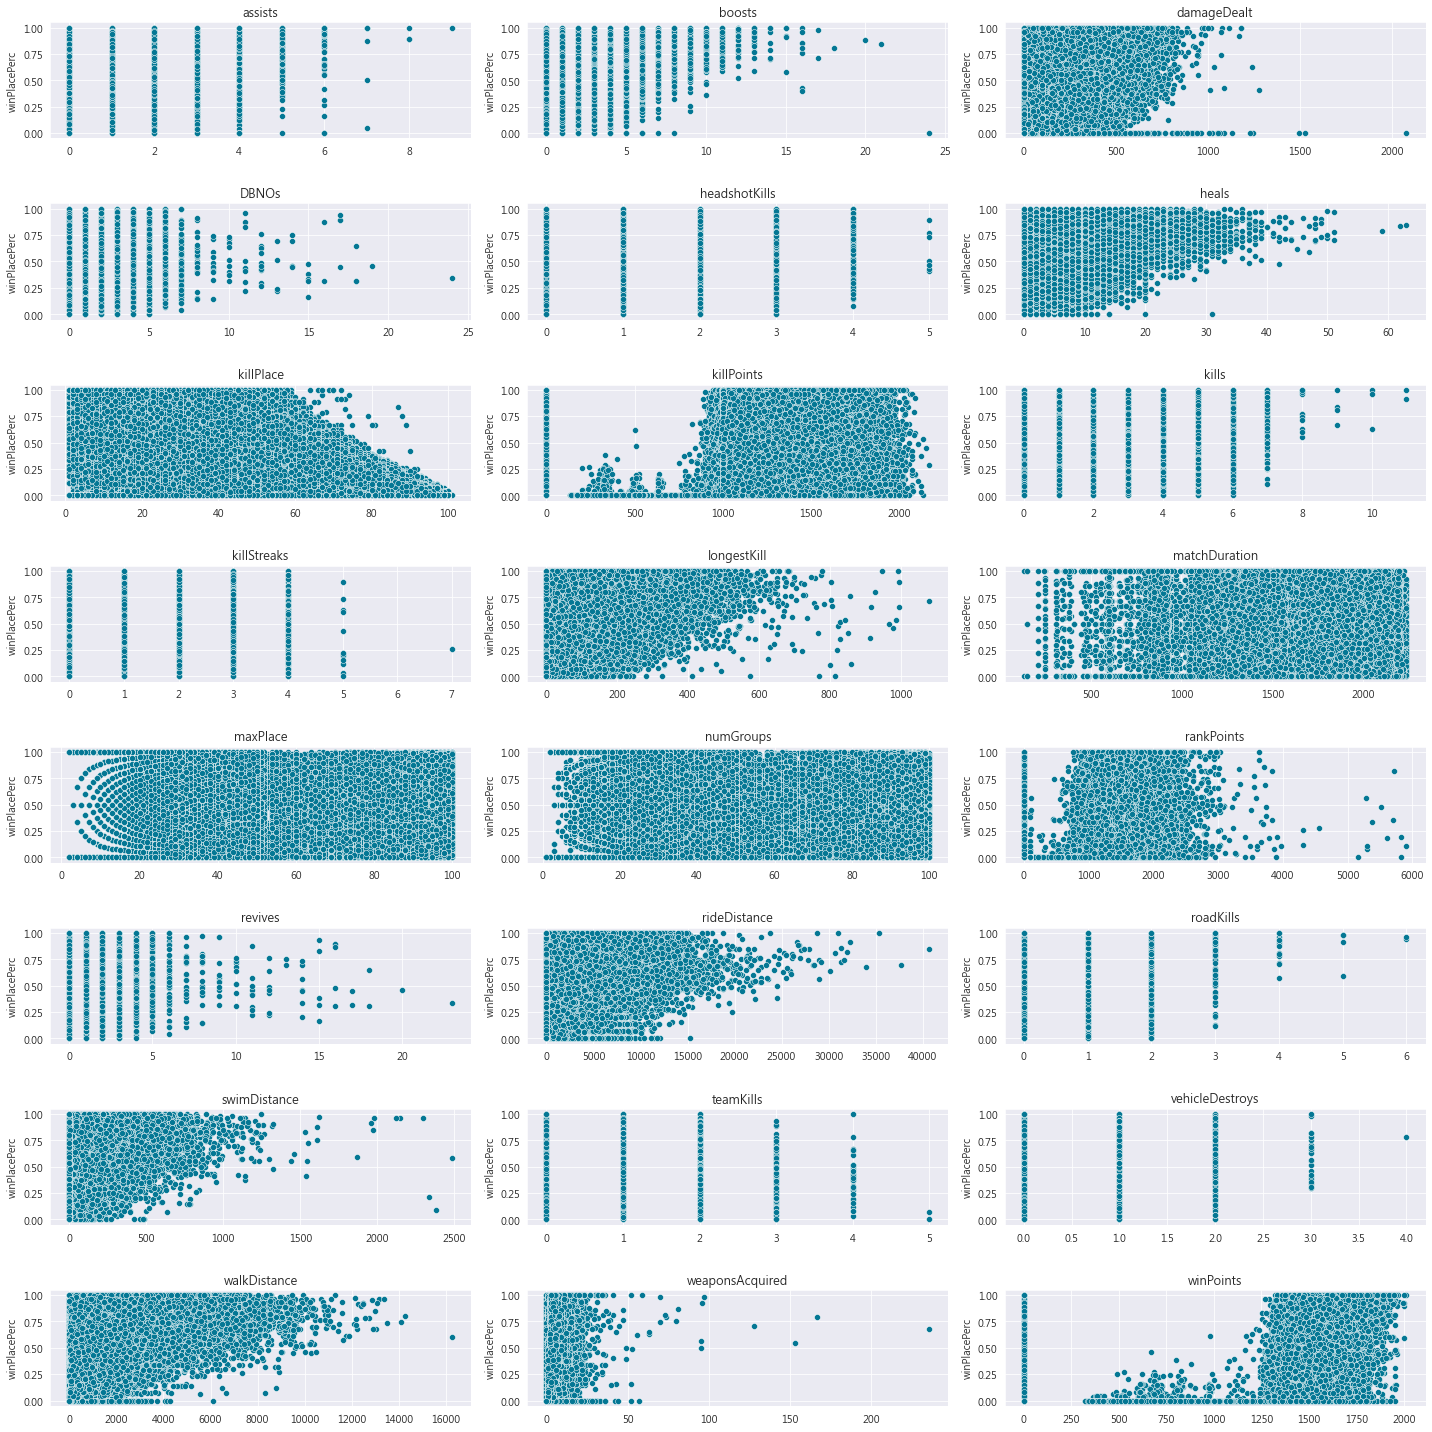

In [107]:
# feature_numerical 取得數值型特徵
feature_numerical = [feature for feature in train.columns if train[feature].dtypes != 'O']

# 觀察數值類型的特徵
plt.figure(figsize=(20,20))
for i, source in enumerate(feature_numerical):
    if source == "winPlacePerc":
        continue
    # 指定好子圖的位置 
    plt.subplot(8, 3, i+1)
    # scatterplot
    sns.scatterplot( x =source , y="winPlacePerc", data = train, color = '#047794').set(xlabel=None)
    plt.title(source)
    
    # 增加子圖間的間隙
    plt.tight_layout(h_pad=3)
plt.show()

### EDA (Exploratory Data Analysis) 探索式資料分析 (特別關注)
> - 觀察擊殺數為0的玩家與傷害的關係 : 可以看出明顯無貢獻
> - 查看吃雞的人平均移動距離 : 至少要跑3000ㄟ , 是在當兵喔
> - 擊殺數與最終排名的關係 : 明顯看出殺敵數越多, 排名越好

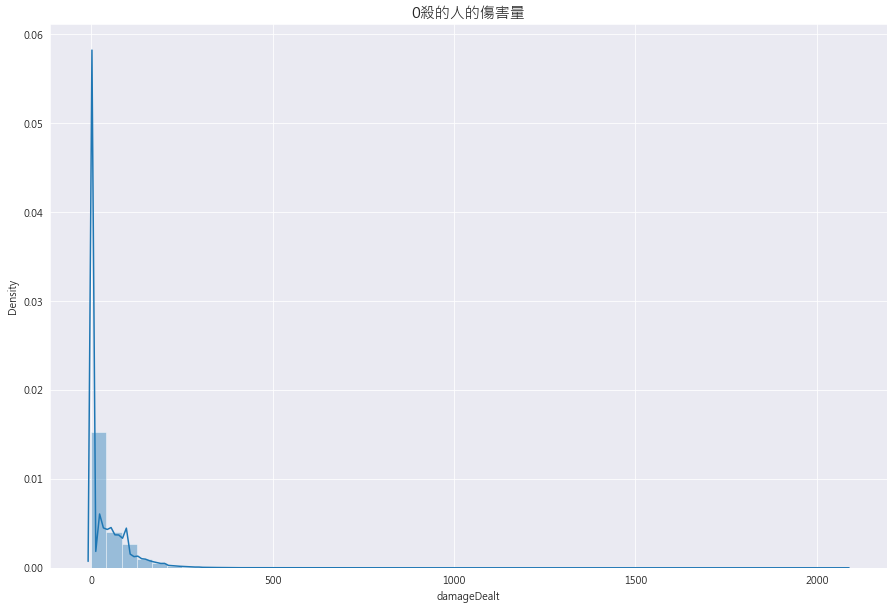

In [108]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("0殺的人的傷害量",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

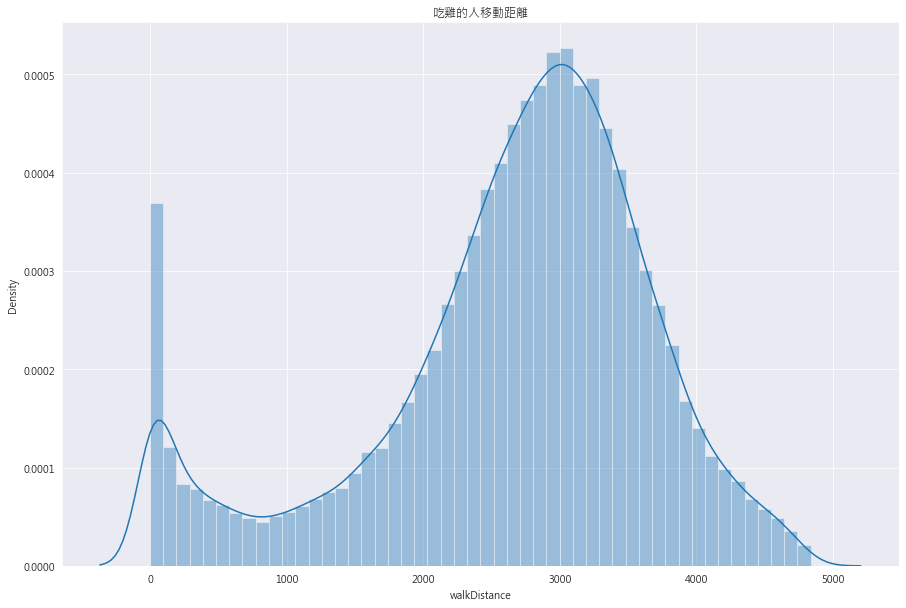

In [109]:
winner_data=train[train['winPlacePerc'] == 1].copy()
winner_data = winner_data[winner_data['walkDistance'] < winner_data['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("吃雞的人移動距離")
sns.distplot(winner_data['walkDistance']) 
plt.show()

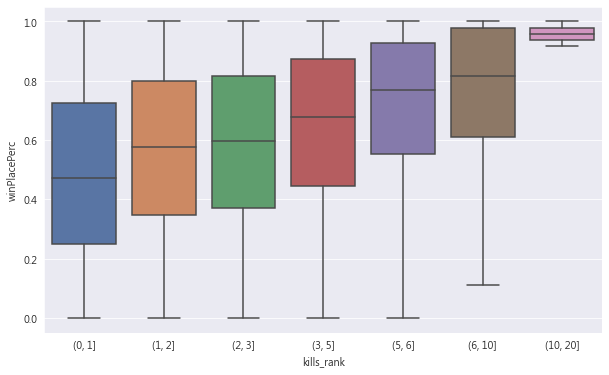

In [110]:
# 新增一個排名區間的特徵
df_kills_rank = train.copy()
df_kills_rank['kills_rank'] = pd.cut(df_kills_rank['kills'], [0, 1, 2, 3, 5, 6, 10, 20])
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'kills_rank', y = 'winPlacePerc', data = df_kills_rank, palette = 'deep')
plt.show()

## 特徵工程
>1. 特徵建構: 從原始數據中人工的構建新的特徵，取代原始數據的特徵  
>2. 特徵提取: 將機器學習演算法不能識別的原始數據，轉化為演算法可以識別的特徵
    - 特徵提取的首要任務是將變數從文字轉換成數字，連續數值轉為離散數值，以利統計與導入演算法模型
>3. 特徵選擇: 從所有的特徵中選擇一組最好的特徵集，捨去無關的特徵，保留相關性高的特徵
    - 使用相關性作圖(Pearson相關係數)，顏色較淺的部分為沒有關係的，顏色偏藍就是正相關，顏色偏紅就是負相關，而我們在意的是與poi有相關性無論正負，若是值越接近0，即是要被剃除的特徵。

#### 1. 特徵建構

In [111]:
# 將步行距離與游泳距離加總
train['total_Distances']= train['swimDistance'] + train['walkDistance']
test['total_Distances']= test['swimDistance'] + test['walkDistance']
# 將提升性道具加總
train['total_boots']= train['boosts'] + train['heals']
test['total_boots']= test['boosts'] + test['heals']
# 將殺傷類的加總
# train['total_damage']= train['DBNOs'] + train['assists']

#### 2. 特徵提取

In [112]:
# 將這些數值特徵分成四等分，精簡模型的數值分析，並做 LabelEncoder
# for column in train.columns:
#     train[column] = pd.cut(train[column], 10)
#     train[column] = LabelEncoder().fit_transform(train[column])
# train.head(10)

#### 3.特徵選擇
- 使用皮爾遜積差相關係數來做特徵選擇

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

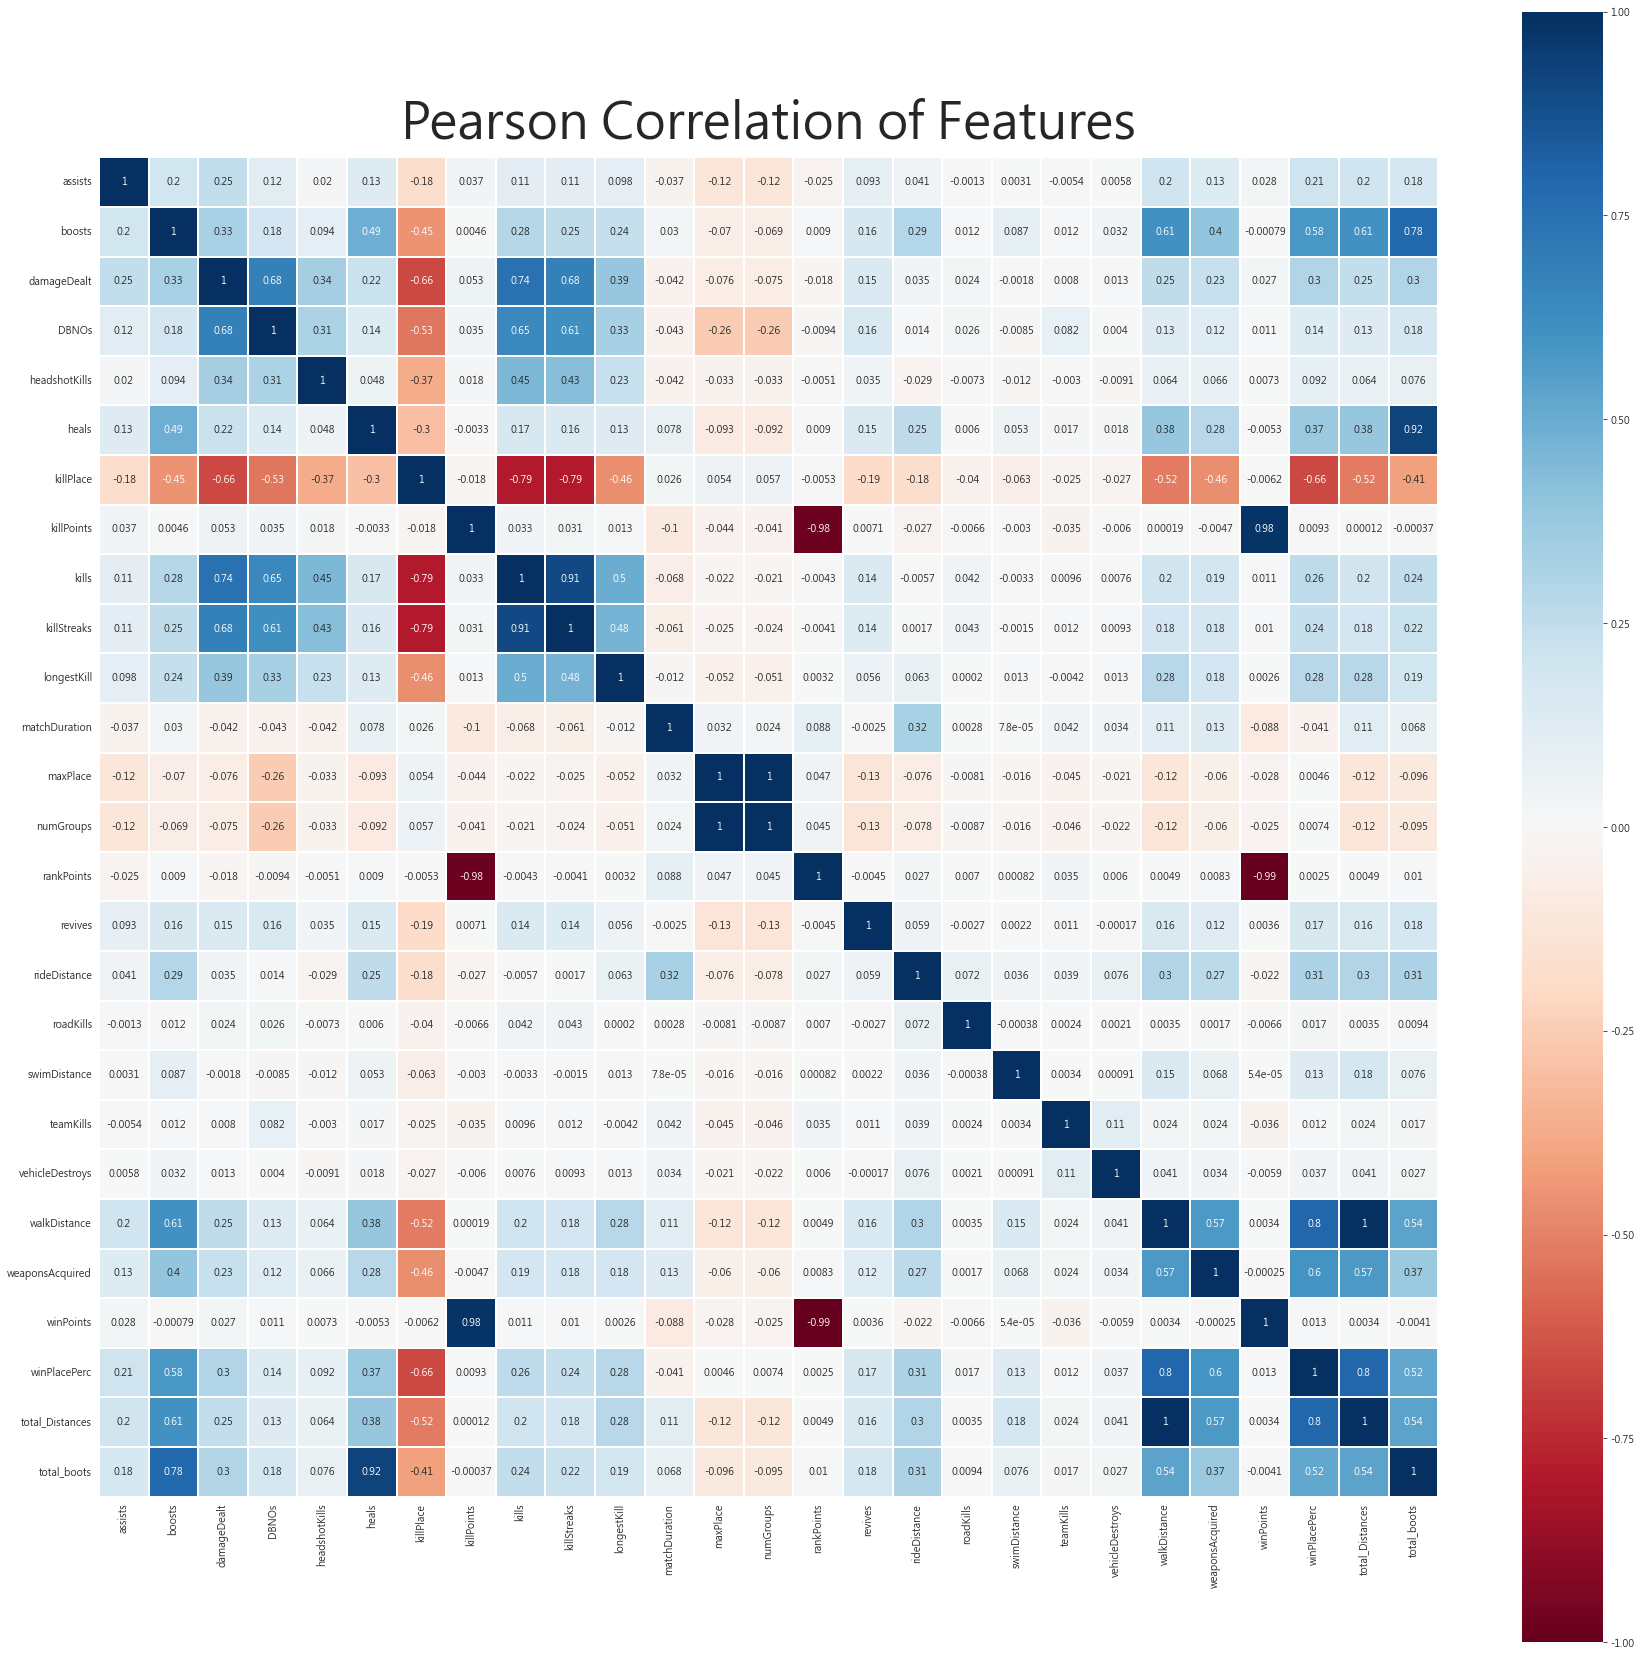

In [113]:
# 先建立空圖
colormap = plt.cm.RdBu
plt.figure(figsize = (30, 30))
plt.title('Pearson Correlation of Features', y = 1.01, size = 50)

# 再將資料加入圖中
sns.heatmap(train.astype(float).corr(), linewidths = 0.1, vmin = -1.0 ,vmax = 1.0, square = True, cmap = colormap, 
            linecolor = 'white', annot = True, xticklabels = True, yticklabels = True)

In [114]:
# 觀察相關性
train.astype(float).corr()['winPlacePerc'].sort_values()

killPlace           -0.6610370946117171
matchDuration     -0.040957166461137735
rankPoints         0.002513864977261746
maxPlace          0.0046226211565251595
numGroups          0.007377397677177699
killPoints         0.009324336360697837
teamKills          0.011655779773727885
winPoints          0.012903535555610003
roadKills           0.01715226249737488
vehicleDestroys       0.037218528155867
headshotKills       0.09239494943312006
swimDistance        0.13135309777304283
DBNOs               0.13744010877894672
revives             0.17057490190496574
assists              0.2083503656373435
killStreaks         0.24135789108863376
kills               0.26290427379242043
longestKill          0.2770524613830262
damageDealt          0.3027616409622833
rideDistance         0.3121464172090672
heals                0.3738819009962487
total_boots          0.5208712266145725
boosts               0.5819641757868754
weaponsAcquired      0.5997047142428047
walkDistance         0.7954976201682411


In [115]:
# 取得相關性絕對值大於 0.1 的特徵
# feature_select = []
# for i in range(len(train.astype(float).corr()['winPlacePerc'])):
#     if abs(train.astype(float).corr()['winPlacePerc'].values[i]) >= 0.10:
#         feature_select.append(train.astype(float).corr()['winPlacePerc'].index[i])

# # 刪除較不相關的欄位
# for column in train.columns:
#     if column not in feature_select:
#         train = train.drop([column], axis = 1)
          # test = test.drop([column], axis = 1)
        
# 觀察修正後的訓練資料尺寸
print(f'train shape: {train.shape}')

train shape: (3811347, 27)


## 準備訓練資料

In [116]:
train = train.drop(['winPlacePerc'], axis = 1) # 刪除指定column
X_train = train
X_test = test
print(f'train shape: {train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'test shape: {test.shape}')

train shape: (3811347, 26)
y_train shape: (3811347,)
test shape: (1934174, 26)


## 建立模型
- 建立需要用到的模型, 再利用交叉驗證判斷好壞

In [117]:
# mm = MinMaxScaler().fit(X_train)
# X_train = mm.transform(X_train)
# X_test = mm.transform(X_test)

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train_MinMaxScaler = pd.DataFrame(X_train)
X_train_MinMaxScaler.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,0.0,0.0,0.0,0.5899999737739563,0.5718894004821777,0.0,0.0,0.0,0.5575094819068909,0.26530611515045166,0.2525252401828766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0150633929297328,0.0042372881434857845,0.7282662987709045,0.014945652335882187,0.0
1,0.0,0.0,0.04399038478732109,0.0,0.0,0.0,0.5600000023841858,0.0,0.0,0.0,0.0,0.7813687920570374,0.24489794671535492,0.24242423474788666,0.251226544380188,0.0,1.1058723003998239e-07,0.0,0.004444066900759935,0.0,0.0,0.08825701475143433,0.02118644118309021,0.0,0.08823888748884201,0.0
2,0.1111111119389534,0.0,0.032692309468984604,0.0,0.0,0.0,0.46000000834465027,0.0,0.0,0.0,0.0,0.5632129311561584,0.4897959232330322,0.46464645862579346,0.25241076946258545,0.0,0.0,0.0,0.0,0.0,0.0,0.009955071844160557,0.008474576286971569,0.0,0.009877259843051434,0.0
3,0.0,0.0,0.01582031324505806,0.0,0.0,0.0,0.7400000095367432,0.0,0.0,0.0,0.0,0.6192965507507324,0.29591837525367737,0.2929292917251587,0.2383691370487213,0.0,0.0,0.0,0.0,0.0,0.0,0.012478458695113659,0.012711863964796066,0.0,0.012380923144519329,0.0
4,0.0,0.0,0.048076923936605453,0.0,0.0,0.0,0.4399999976158142,0.0,0.09090909361839294,0.1428571492433548,0.05414546653628349,0.6135931611061096,0.9693877696990967,0.9494949579238892,0.2640839219093323,0.0,0.0,0.0,0.0,0.0,0.0,0.0030619152821600437,0.008474576286971569,0.0,0.003037982387468219,0.0


In [131]:

rf = RandomForestRegressor(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=8, bootstrap=False)

# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

# LightGBM
model_lgb = lgb.LGBMRegressor()


In [137]:
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_train)

print('rf R2 score：', r2_score(y_train, rf_pred))
print('rf MSE：', mean_squared_error(y_train, rf_pred))
print('rf RMSE：', np.sqrt(mean_squared_error(y_train, rf_pred)))

rf R2 score： 0.857086504310372
rf MSE： 0.011889013221025561
rf RMSE： 0.10903675169879906


In [138]:
model_xgb.fit(X_train, y_train)
xgb_pred = model_xgb.predict(X_train)

print('xgb R2 score：', r2_score(y_train, xgb_pred))
print('xgb MSE：', mean_squared_error(y_train, xgb_pred))
print('xgb RMSE：', np.sqrt(mean_squared_error(y_train, xgb_pred)))

[10:55:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


xgb R2 score： 0.9198919214273422
xgb MSE： 0.0066642147
xgb RMSE： 0.08163464


In [132]:
model_lgb.fit(X_train, y_train)
lgb_pred = model_lgb.predict(X_train)

print('lgb R2 score：', r2_score(y_train, lgb_pred))
print('lgb MSE：', mean_squared_error(y_train, lgb_pred))
print('lgb RMSE：', np.sqrt(mean_squared_error(y_train, lgb_pred)))

lgb R2 score： 0.9196171813579914
lgb MSE： 0.006687068908129005
lgb RMSE： 0.08177450035389397


In [136]:
# 混合泛化預測檔 (依 Kaggle 傳回分數調整比重, 越準確者比重越高, 依資料性質有所不同)
blending_pred = xgb_pred*0.5 + lgb_pred*0.5

print('lgb R2 score：', r2_score(y_train, blending_pred))
print('lgb MSE：', mean_squared_error(y_train, blending_pred))
print('lgb RMSE：', np.sqrt(mean_squared_error(y_train, blending_pred)))

lgb R2 score： 0.9211815961631407
lgb MSE： 0.006556924807938628
lgb RMSE： 0.08097484058606493


### 測試模型並輸出

In [ ]:
sub = pd.read_csv('./data/pubg/sample_submission_V2.csv')
submission = pd.DataFrame()
submission['Id'] = sub['Id']
submission['winPlacePerc'] = 
submission.to_csv('./data/pubg/submission_blending_pred.csv', index = False)